In [ ]:
## Info about why we are using this methodology, cite the social network paper + supplement

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
import tempfile
import os
import sys
%matplotlib inline
import random

In [24]:
import networkx as nx
#import community

## Import Independent Cascade Model

In [26]:
import independent_cascade as ic

**Info:**
This is a method of "infecting" a network, which is to say that the data do not have any predefined markers of "infected" or "uninfected" and the infected nodes will be assigned synthetically using the "independent cascades" algorigthm [1].

[1] David Kempe, Jon Kleinberg, and Eva Tardos. Maximizing the spread of influence through a social
network. In Proceedings of the ninth ACM SIGKDD international conference on Knowledge
discovery and data mining, pages 137–146, 2003.

In [5]:
G_fb = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype = int)
print nx.info(G_fb)

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


/Users/jackiemartinez/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


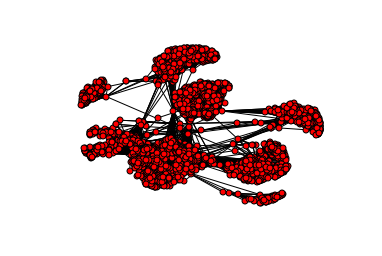

In [6]:
spring_pos = nx.spring_layout(G_fb)
plt.axis("off")
nx.draw_networkx(G_fb, pos = spring_pos, with_labels = False, node_size = 35)


Name: 
Type: Graph
Number of nodes: 2002
Number of edges: 10000
Average degree:   9.9900


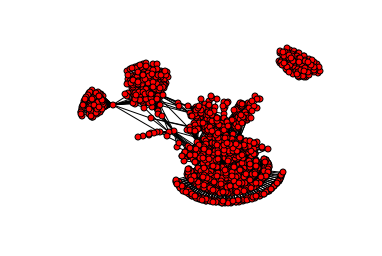

In [8]:
# Weighted 
G_fb_w = nx.read_weighted_edgelist("facebook_combined_first10000w.txt")
print nx.info(G_fb_w)
spring_pos_w = nx.spring_layout(G_fb_w)
plt.axis("off")
nx.draw_networkx(G_fb_w, pos = spring_pos_w, with_labels = False, node_size = 35)


In [11]:
## Data Separation
df_over_two = [(u,v,d) for (u,v,d) in G_fb_w.edges(data=True) if d['weight'] > 2]
df_under_two = [(u,v,d) for (u,v,d) in G_fb_w.edges(data=True) if d['weight'] <= 2]
print "W > 2:",len(df_over_two)
print "W <= 2",len(df_under_two)

W > 2: 4830
W <= 2 5170


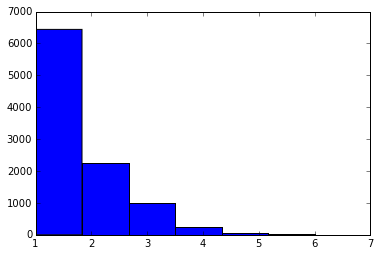

0.3558


In [112]:
DG = nx.DiGraph()
DG.add_edges_from([(1,2), (1,3), (1,5), (2,1), (3,2), (4,2), (4,3), \
(4,6), (5,3), (5,4), (5,6), (6,4), (6,5)], act_prob=0.2)
# spring_pos = nx.spring_layout(DG)
# nx.draw_networkx(DG, pos = spring_pos, with_labels = False, node_size = 35)


outcome_len = []
for n in np.arange(0,10000):
    H = ic.independent_cascade(DG,[6])
    outcome_len.append(len(H) - 1)
plt.hist(outcome_len,bins=6)
plt.show()
print len([elt for elt in outcome_len if elt > 1])/10000.

In [89]:
random.randint(0,1)

0

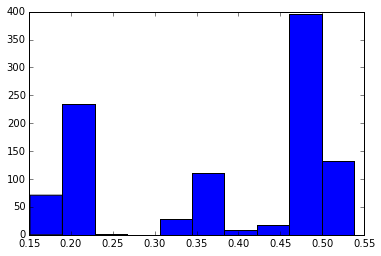

In [114]:
# Try with a large dataset

def test_cascade(tuple_list):
    DG = nx.DiGraph()
    DG.add_edges_from(tuple_list, act_prob=0.2)
    
    rand_row = random.randint(0, len(tuple_list) - 1)
    rand_col = random.randint(0,1)
    
    try:
        my_seed = tuple_list[rand_row][rand_col]
    except IndexError:
        print len(tuple_list),rand_row,rand_col
        
    outcome_len = []
    n_trials = 1000
    for n in np.arange(0,n_trials):
        H = ic.independent_cascade(DG,[my_seed])
        outcome_len.append(len(H) - 1)
    prop_over1 = len([elt for elt in outcome_len if elt > 1])/(n_trials * 1.)
    return prop_over1

prop_list = []
for n in np.arange(0,1000):
#     mylist = [ ( random.randint(0, 50), random.randint(0, 50) ) for k in range(150) ]
#     myList = (list(set(mylist)))
    myList = [(1,2), (1,3), (1,5), (2,1), (3,2), (4,2), (4,3), \
(4,6), (5,3), (5,4), (5,6), (6,4), (6,5)]
    prop_list.append(test_cascade(myList))

plt.hist(prop_list)
plt.show()
 

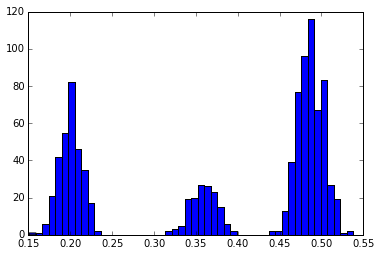

In [116]:
plt.hist(prop_list,bins=50)
plt.show()

In [5]:
df = np.loadtxt("com-dblp.ungraph.txt")
idx = random.sample(xrange(0,df.shape[0]),10000)
idx = (list(set(idx)))
idx.sort()
df_rand10000 = df[idx]
np.savetxt("dblp_rand10000.txt",df_rand10000,fmt="%d")

In [6]:
df_first10000= df[0:10000]
np.savetxt("dblp_first10000.txt",df_first10000,fmt="%d")

Name: 
Type: Graph
Number of nodes: 8655
Number of edges: 10000
Average degree:   2.3108


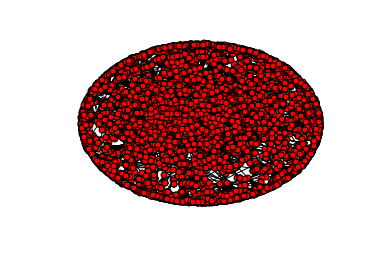

In [7]:
G_dblp_first = nx.read_edgelist("dblp_first10000.txt", create_using = nx.Graph(), nodetype = int)
print nx.info(G_dblp_first)
spring_pos = nx.spring_layout(G_dblp_first)
plt.axis("off")
nx.draw_networkx(G_dblp_first, pos = spring_pos, with_labels = False, node_size = 35)

Name: 
Type: Graph
Number of nodes: 18373
Number of edges: 10000
Average degree:   1.0886


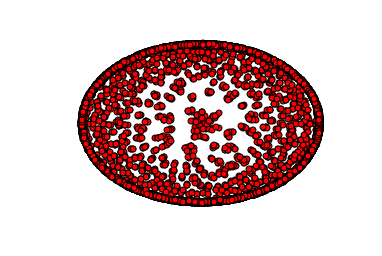

In [8]:
G_dblp_rand = nx.read_edgelist("dblp_rand10000.txt", create_using = nx.Graph(), nodetype = int)
print nx.info(G_dblp_rand)
spring_pos = nx.spring_layout(G_dblp_rand)
plt.axis("off")
nx.draw_networkx(G_dblp_rand, pos = spring_pos, with_labels = False, node_size = 35)


In [17]:
def add_weights_and_save(sample,df,filename):
    if len(sample) != df.shape[0]:
        print "ERROR: DF andSamples must be same length"
        return -1
    else:
        df_weighted = np.zeros((len(sample),3))
        df_weighted[:,:-1] = df
        df_weighted[:,-1] = sample
        np.savetxt(filename,df_weighted,fmt="%d")
        return 1
            

In [13]:
import scipy.stats

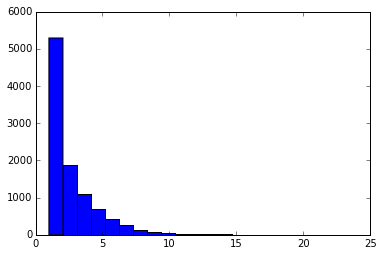

In [14]:
distribution = scipy.stats.expon(loc=1,scale=2)
sample = distribution.rvs(size=10000)
sample = [np.round(elt) for elt in sample]
plt.hist(sample,bins=20)
plt.show()